### Ennonce : Utilisation des réseaux multi-couches pour l’analyse des sentiments des phrases issues d’une base d’exemples qui contient des phrases étiquetées avec un sentiment positif ou négatif.

#### <span style="color:blue">La solution au dessous est proposée par le trinome:</span>
##### <span style="color:green">Ahmed MELLOUK</span>.
##### <span style="color:green">Nora YOUSSEFI</span>.
##### <span style="color:green">Omar RAGHLI</span>.


# <span style="color:#170770">1) Exploration du DataSet<span>

###### DataSet est compris par 1000 commentaires, étiqueté par 1 si positif, 0 si negatif.

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns #for data visualization

In [44]:
#Lecture des donnnees a partir du fichier text
data = []

f = open("imdb_labelled.txt", "r") #lecture du fichier 'imdb_labelled.txt'

for review in f:
    x = review.strip().split('\t')
    data.append([x[0], int(x[1])])  #['commentaire','sentiment']

In [45]:
df = pd.DataFrame(data, columns=['review', 'label']) #Creation d'un dataframe pour notre fichier text
df.head(10)

,review,label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1
5,"The rest of the movie lacks art, charm, meanin...",0
6,Wasted two hours.,0
7,Saw the movie today and thought it was a good ...,1
8,A bit predictable.,0
9,Loved the casting of Jimmy Buffet as the scien...,1


In [46]:
#1000 lignes, 2 colonnes
df.shape

(1000, 2)

In [47]:
#500 review negatif et positifs
df.label.value_counts()

0    500
1    500
Name: label, dtype: int64

In [48]:
reviews=df.review.copy() #array of phrases
labels=df.label.copy() #array of labels

reviews

0      A very, very, very slow-moving, aimless movie ...
1      Not sure who was more lost - the flat characte...
2      Attempting artiness with black & white and cle...
3           Very little music or anything to speak of.  
4      The best scene in the movie was when Gerardo i...
                             ...                        
995    I just got bored watching Jessice Lange take h...
996    Unfortunately, any virtue in this film's produ...
997                     In a word, it is embarrassing.  
998                                 Exceptionally bad!  
999    All in all its an insult to one's intelligence...
Name: review, Length: 1000, dtype: object

##  <span style="color:green">a) Visualisation</span>.


###### On observe qu’on a autant d’opinions négatives que positives.

<AxesSubplot:xlabel='label', ylabel='count'>

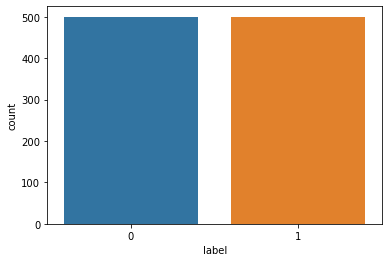

In [49]:
sns.countplot(x="label",data=df)

##  <span style="color:green">b) Mots Frequents avant filtrage</span>.


###### La mots frequents dans notre dataset avant traitment, sont des stopwords, ie, des mots neutres, tel que "the","is"

In [50]:
from nltk.tokenize import word_tokenize
from collections import Counter

tokens=Counter() #dictionnaire contenant chaque mot et son nombre d'apparition

for review in reviews:  
    for word in word_tokenize(review):
        tokens[word]+=1 


tokens_df = pd.DataFrame.from_dict(dict(tokens.most_common(30)), orient='index').reset_index()
tokens_df = tokens_df.rename(columns={'index':'word', 0:'count'})

tokens_df

,word,count
0,.,905
1,the,657
2,",",649
3,and,418
4,a,413
5,of,370
6,is,338
7,I,285
8,to,247
9,it,234


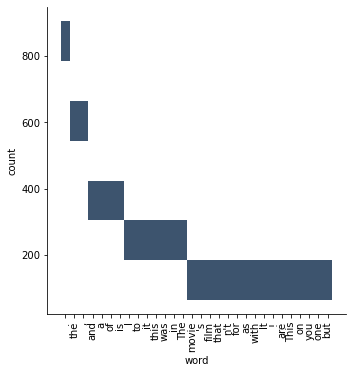

In [51]:
graph=sns.displot(data=tokens_df, x="word", y="count")
graph.set_xticklabels(rotation=90) 

# <span style="color:#170770"> 2) Traitement des donnees </span>

In [52]:
import nltk #Natural Language Toolkit
import re #regex
from nltk.corpus import stopwords

###### Cette Section contient des fonctions de filtrage des donnees, en realisant les taches suivants.
<ol>
  <li>Suppression Des mots de longueur inferieur à 2 </li>
  <li>Supprimmer les caracteres speciaux dans les mots</li>
  <li>Lemmatization (convertir les mots à leur racine)</li>
</ol>

In [53]:
def removeByLength(review):  #suprimmer les mots de longueur < 2
    for word in review:
        if len(word)<=2:
            review=list(filter((word).__ne__, review))
    return review
    
    
#Cleaning d'un commentaire
def clean(phrase): 
    
    phrase = re.compile('[^a-zA-Z]').sub(' ', phrase).lower().split() #suprimmer les caracteres speciaux
    
    #lemmatization (greatly , greatness) => (great)
    #stopwords (suprimmer les mots neutres, tel que: in,out,i,am,if, ...)
    phrase = [nltk.WordNetLemmatizer().lemmatize(word) for word in phrase if not word in stopwords.words('english')]
    
    phrase=removeByLength(phrase) #filtrer par longueur
    
    phrase = ' '.join(phrase)
    
    return phrase


clean("massive pg pg level 10 12218 massive unlockable character massive game")

'massive level massive unlockable character massive game'

###### Creation d'un datafarme des donnees apres traitement

In [54]:
#Cleaning de tous les commentaire dans notre dataset
cleaned_dataset=[]

for i in range(len(reviews)):
    reviews[i]=clean(reviews[i])

    
for i in range(len(reviews)):
    cleaned_dataset.append([reviews[i],labels[i]])
    
    
df_cleaned = pd.DataFrame(cleaned_dataset, columns=['clean_review', 'label'])
df_cleaned.head()

,clean_review,label
0,slow moving aimless movie distressed drifting ...,0
1,sure lost flat character audience nearly half ...,0
2,attempting artiness black white clever camera ...,0
3,little music anything speak,0
4,best scene movie gerardo trying find song keep...,1


# <span style="color:#170770"> 3) Extraction des caractéristiques </span>

In [55]:
#librairie pour extraire les caracteristiques & creation du vecteur de carateristiques
from sklearn.feature_extraction.text import CountVectorizer as CV 

import pandas as pd

###### a. Extraction des caracteristiques a l'aide du CountVectorizer
###### b. Convertir chaque opinion a un vecteur, ou chaque valeur est le nombre d'occurence de la caracteristique dans l'opinion

In [56]:
rev2vec=[] #liste des vecteur des carateristiques

cv = CV() #instance du CountVectorizer()

cv.fit(list(reviews)) #Creation d'un dictionnaire contenant tous les mots dans notre DataSet


for i in range(len(reviews)):
    rev2vec.append(cv.transform([reviews[i]]).toarray()[0]) #convertir commentaire => vecteur binaire
   

columns = cv.get_feature_names() #Liste des caracteristiques (mots)


df=pd.DataFrame(rev2vec, columns= columns, index= list(range(len(reviews)))) #Dataset final (apres traitement)

df["label"] = list(labels)

df

,aailiyah,abandoned,ability,abroad,absolutely,abstruse,abysmal,academy,accent,accessible,...,yet,young,younger,youthful,youtube,yun,zillion,zombie,zombiez,label
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
df.shape

(1000, 2677)

# <span style="color:#170770"> 4) Échantillon d'Apprentissage et Test </span>

In [58]:
from sklearn.model_selection import train_test_split  #libraire pour separer les donnees

###### On separe les donnees en deux liste, une d'opinions et l'autre des sentiments. 

In [59]:
# Données + classes cibles
# data   = np.array(df.values[:,1:2733], dtype=np.float32) #Données d'entraînement (Input)

data   = np.array(df.values[:,1:2676], dtype=np.float32) #Données d'entraînement (Input)
target = df.values[:,-1] #Résultats a prédire (Output) 



###### 20% de nos donnees seront dédié pour le test, et le reste pour l'apprentissage

In [60]:
# 200 exemples pour le test
(trainX, testX, trainY, testY) = train_test_split(data, target, test_size=0.2)

# trainX
len(trainX)

800

In [61]:
#Convertir les valeurs cibles en liste de probabilite de chaque valeur
#1 => [1,0]
#0 => [0,1]  

trainYC = np.array(list(map(lambda x: [1,0] if x == 1 else [0,1], trainY))) #Cible pour trainX
testYC = np.array(list(map(lambda x: [1,0] if x == 1 else [0,1], testY))) #Cible pour testX

trainYC

array([[0, 1],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [0, 1]])

# <span style="color:#170770"> 5) Perceptron Multicouches </span>

In [62]:
class MultiLayerPerceptron:
    
    def __init__(self, arch , alpha = 0.1):
        
        self.W = {} #poids
        self.B = {} #biais
        
        # Taux d'adaptation (learning rate)
        self.alpha = alpha
        
        
        # Architecture :nbre de couches et nombre de neurones par couche
        self.arch = arch
        
        
        # Initialisation des poids: valeurs issues d'une distribution normale
        for i in np.arange(1,len(self.arch)):  
            
            # Un valeur aleatoire pour les poids
            w = np.random.randn(self.arch[i], self.arch[i-1])
            self.W[i] = w/np.sqrt(self.arch[i])
            
            # Un valeur aleatoire pour les biais
            b = np.random.randn(self.arch[i],1)
            self.B[i] = b/np.sqrt(self.arch[i])            
            
     
    
    #Fonction d'activation sigmoid
    def sigmoid(self, x):
        return 1.0/(1 + np.exp(-x))
    
    
    def dsigmoid(self, x): 
        return x * (1 - x)
    
    
    
    #Calcul et mémorisation de l'état de tous les neurones du réseau 
    def forward_pass(self, x):
        a = np.atleast_2d(x).T
        
        stats = {}
        stats[0] = a
        
        for layer in np.arange(1, len(self.arch)):
            a = self.sigmoid(np.dot(self.W[layer], a) + self.B[layer])
            stats[layer] = a
            
        return stats    
    
    
    
    #Fonction qui retourne le sentiment d'un vecteur d'entree en parcourant tous les couches
    def predict(self, X):
        
        a = np.atleast_2d(X).T
        
        for layer in np.arange(1, len(self.arch)):
            a = self.sigmoid(np.dot(self.W[layer], a) + self.B[layer])
        
        return a
    
    
    
    #Calcul de l'erreur quadratique moyenne
    def quadratic_loss(self, X, Y):
        Y = np.atleast_2d(Y).T
        predictions = self.predict(X)
        n = X.shape[0]
        loss = (1/n) * 0.5 * np.sum((predictions - Y) ** 2) 
        return loss 
    
    
    
    #Calcul des gradients locaux 
    def compute_gradient(self, x, y):
     
        L = len(self.arch) - 1 
        
        #Gradients
        Gw = {}
        Gb = {}
        
        A = self.forward_pass(x)
        
        # Les vecteurs delta  
        D = {}
        y = np.atleast_2d(y).T
        deltaL = (A[L] - y) * self.dsigmoid(A[L])
        D[L] = deltaL # Pour la sortie 
        
        # Calculer les vecteurs delta des autres couches en utilisants les vecteurs delta de la couche suivante
        for l in np.arange(L-1, 0, -1):
            D[l] = (self.W[l+1].T.dot(D[l+1])) * self.dsigmoid(A[l])
        
        for l in np.arange(L, 0, -1):
            Gb[l] = D[l]
            Gw[l] = D[l].dot(A[l-1].T)        
       
        return (Gw, Gb)
    
    
    
    # Mise à jour par rapport à l'erreur moyenne
    def update_with_bloc(self, bloc):
      
        m = len(bloc)
       
        # Gradients locaux
        GCw = {}
        GCb = {}
        
        # Initialiser à zeros 
        for i in np.arange(1,len(self.arch)):
            GCw[i] = np.zeros(self.W[i].shape)
            GCb[i] = np.zeros(self.B[i].shape)
            
        # Calcul des gradients
        for x, y in bloc:
            Gw, Gb = self.compute_gradient(x, y)
            for i in np.arange(1,len(self.arch)): 
                GCw[i] += Gw[i]
                GCb[i] += Gb[i]
                
        # Mettre à jour les poids 
        for l in np.arange(1,len(self.arch)):
            self.W[l] = self.W[l] - (self.alpha/m)*(GCw[l])
            self.B[l] = self.B[l] - (self.alpha/m)*(GCb[l])
    
    
    
    
    # Iteration: entrainement en utilisant tous les exemples, un bloc de taille bloc_size chaque fois
    def train(self, D, bloc_size):
        
        train_size = len(D)
        np.random.shuffle(D) 
        
        # Bloc d'exemples
        blocs = [D[k : k + bloc_size] for k in range(0, train_size, bloc_size)]
        
        for bloc in blocs: # Mise à jour suite au passage de chaque bloc
            self.update_with_bloc(bloc)
  



    #Entrainement
    def fit(self, X, Y, bloc_size = 20, iterations = 10000, error_min = 0.001, displayPeriod = 5000):
     
        # Exemples avec X et Y Assemblés
        D = list(zip(X,Y))
        
        # Erreurs
        errors = [self.quadratic_loss(X,Y)]   # Erreur initiale    
        
        iter = 0
        print("Iteration: {}-{}, Error: {:.6f}".format(iter, iterations,errors[iter]))
        while iter < iterations and errors[iter] > error_min: # Tour de boucle 
            
            self.train(D, bloc_size)  # Mettre à jour 
            errors.append(self.quadratic_loss(X,Y))         # Nouvelle erreur
          
            if (iter+1) % displayPeriod == 0:
                print("Iteration: {}-{}, Error: {:.6f}".format(iter + 1, iterations,errors[iter]))
            iter += 1
        
        if errors[iter] < error_min: # Erreur inférieur à la valeur minimale
            print("Fin: erreur minimale atteinte : {:.6f}.", errors[iter])
        elif iter == iterations:
            print("Apprentissage Termine")
       
        return (errors, iter)

# <span style="color:#170770"> 6) Apprentissage </span>

###### L'architecture choisis pour le reseau est:
<ul>
  <li> 4 couches </li>
  <li> Le nombre de neurones par couches est, [ dimension(vecteur d'entree), 15, 15, 2 ]</li>
  <li>Taux d'adaptation = 0.1</li>
</ul>

In [84]:
pmc = MultiLayerPerceptron(arch=[trainX.shape[1],15,15,2], alpha=0.1) #Instance du PMC

(errs, iter_fin) = pmc.fit(trainX, trainYC, iterations=500, bloc_size=5, error_min=0.00001, displayPeriod=20) #Apprentissage

Iteration: 0-500, Error: 0.316362
Iteration: 20-500, Error: 0.243143
Iteration: 40-500, Error: 0.183626
Iteration: 60-500, Error: 0.074495
Iteration: 80-500, Error: 0.025536
Iteration: 100-500, Error: 0.012021
Iteration: 120-500, Error: 0.007930
Iteration: 140-500, Error: 0.006242
Iteration: 160-500, Error: 0.005351
Iteration: 180-500, Error: 0.004792
Iteration: 200-500, Error: 0.004313
Iteration: 220-500, Error: 0.004015
Iteration: 240-500, Error: 0.003746
Iteration: 260-500, Error: 0.003530
Iteration: 280-500, Error: 0.003369
Iteration: 300-500, Error: 0.003237
Iteration: 320-500, Error: 0.003123
Iteration: 340-500, Error: 0.003048
Iteration: 360-500, Error: 0.002974
Iteration: 380-500, Error: 0.002880
Iteration: 400-500, Error: 0.002843
Iteration: 420-500, Error: 0.002773
Iteration: 440-500, Error: 0.002731
Iteration: 460-500, Error: 0.002695
Iteration: 480-500, Error: 0.002674
Iteration: 500-500, Error: 0.002620
Apprentissage Termine


# <span style="color:#170770"> 7) Testing </span>

In [81]:
targetTestR = ['']*(np.array(testY).shape[0])  #Liste des sentiment prédit par le réseau

for index in range(testX.shape[0]): 
    
    #Prediction des sentiment pour l'echantillon du test
    prediction = np.round(pmc.predict(testX[index]),0)[:,0].astype(int) 
    
    if((prediction==np.array([1,0])).all()):  #Si sentiment predit est positif, ajouter 1 au targetTestR
        targetTestR[index] = 1
        
    elif((prediction==np.array([0,1])).all()): #Si sentiment predit est negatif, ajouter 0 au targetTestR
        targetTestR[index] = 0

        
# Sortie calculée      
targetTestRF=list(map(lambda x: '1' if x == 1 else '0', targetTestR)) 

# Sortie réelle pour l'echantillon du test 
testYF=list(map(lambda x: '1' if x == 1 else '0', testY))

len(testYF)

200

# <span style="color:#170770"> 8) Évaluation </span>

###### On voit qu'on a une precision ~ 0.8

In [82]:
from sklearn import metrics

# Taux de la classification correcte (Comparaison entre sortie calculée et réelle) 
metrics.accuracy_score(testYF, targetTestRF) 

0.76

###### Matrice de confusion

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

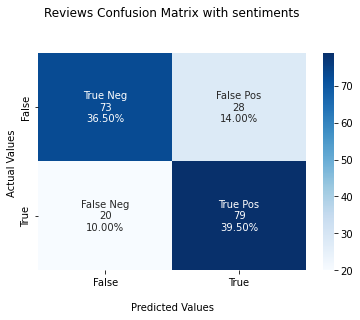

In [83]:
from sklearn.metrics import confusion_matrix

cf_matrix=confusion_matrix(testYF, targetTestRF)


group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Reviews Confusion Matrix with sentiments\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
